In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 150
import glob, os

import networkx as nx
import timeit
import itertools

# Get cleaned data from steps 1 and 2

In [2]:
virus_human = pd.read_csv("../Data/virus_human.csv")
human_human = pd.read_csv("../Data/human_important_for_virus.csv")

In [3]:
genes = pd.read_csv("../Data/human_genes.txt", sep="\t", header=None).iloc[:, 0].values
genes_all = pd.read_csv("../Data/human_genes_all.txt", sep="\t", header=None).iloc[:, 0].values

In [4]:
len(genes), len(genes_all), len(virus_human), len(human_human)

(7482, 21340, 27024, 8788)

# Results from GOrilla (step 2)

In [5]:
# all significant at alpha = 0.05 even after FDR
go_function = pd.read_csv("GO_genes_function.tsv", sep="\t")
go_process = pd.read_csv("GO_genes_process.tsv", sep="\t")

In [6]:
def get_gene_lists(df, ref_gene_set):
    
    genes = df["Genes"].values
    
    genes_cleaned = []
    
    # nested list
    for lst in genes:
        
        genes_list = lst.strip("[]").split(", ")
            
        single_go_list = []
        
        for word in genes_list:
            
            # if the first character is an uppercase letter, then it's a gene name
            if not word[0].isdigit() and word[0].upper() == word[0]:
                
                # make sure that every gene is in the list of original genes, otherwise it's not actually a gene
                # this is because of deprecated gene names. GOrilla uses some old names 
                # don't keep the description of the gene that comes after the hyphen
                if word.split("  -")[0] in ref_gene_set:
                    
                    single_go_list.append(word.split("  -")[0])
        
        genes_cleaned.append(single_go_list)
    
    return genes_cleaned

In [7]:
# Takes several seconds to a minute to run
process_cleaned_genes = get_gene_lists(go_process, genes)
go_process["Genes"] = process_cleaned_genes

function_cleaned_genes = get_gene_lists(go_function, genes)
go_function["Genes"] = function_cleaned_genes

go_process["Number of Genes"] = [len(lst) for lst in go_process["Genes"]]
go_function["Number of Genes"] = [len(lst) for lst in go_function["Genes"]]

go_process = go_process.sort_values("Number of Genes", ascending=False).reset_index(drop=True)
go_function = go_function.sort_values("Number of Genes", ascending=False).reset_index(drop=True)

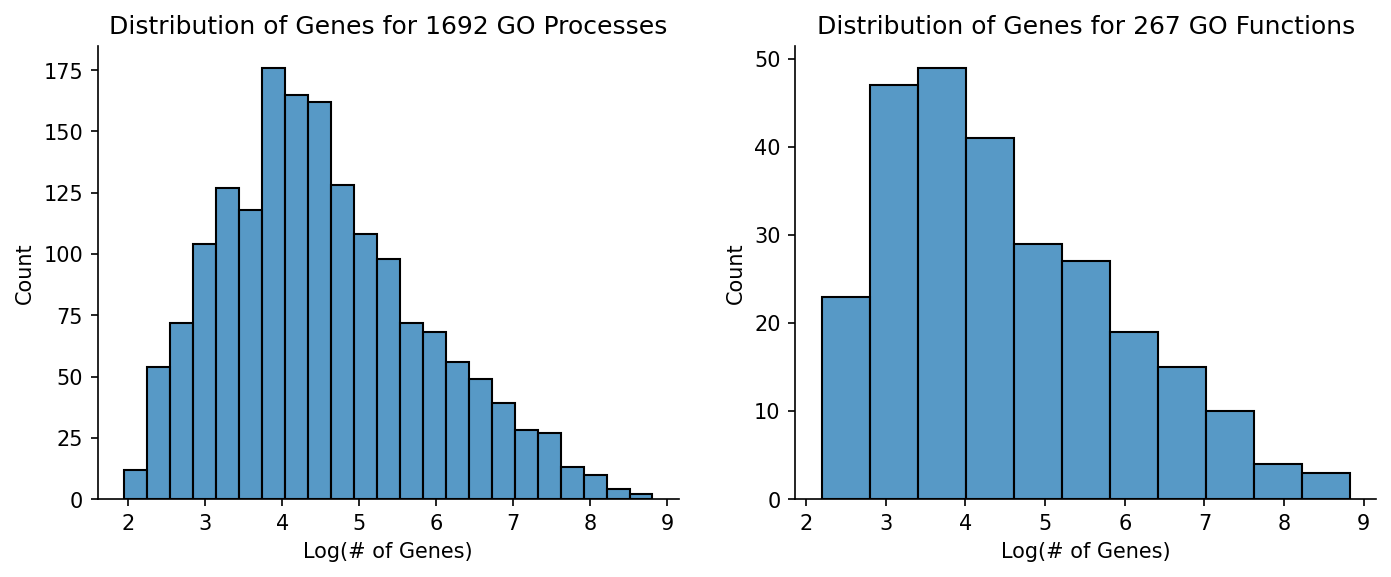

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

sns.histplot(np.log(go_process["Number of Genes"]), ax=ax[0])
ax[0].set_title(f"Distribution of Genes for {len(go_process)} GO Processes")
ax[0].set_xlabel("Log(# of Genes)")

sns.histplot(np.log(go_function["Number of Genes"]), ax=ax[1])
ax[1].set_title(f"Distribution of Genes for {len(go_function)} GO Functions")
ax[1].set_xlabel("Log(# of Genes)")

sns.despine()
plt.show()

# Functional Enrichment

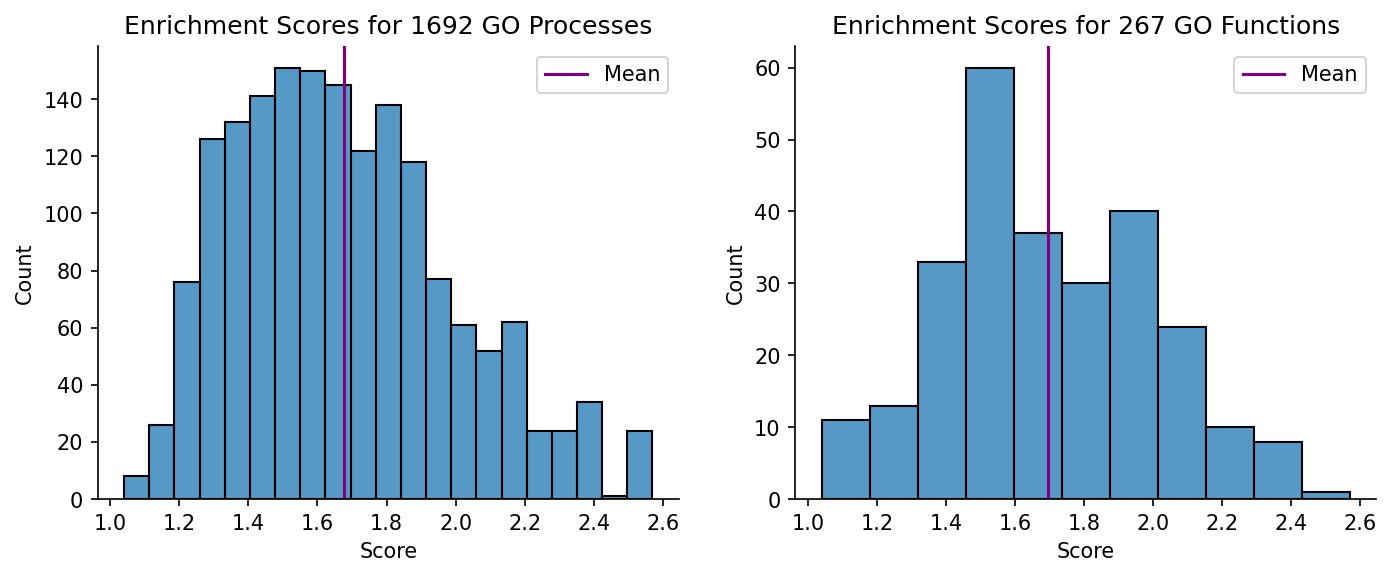

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

sns.histplot(go_process["Enrichment"], ax=ax[0])
ax[0].axvline(x=np.mean(go_process["Enrichment"]), color="purple", label="Mean")
ax[0].set_title(f"Enrichment Scores for {len(go_process)} GO Processes")
ax[0].set_xlabel("Score")
ax[0].legend()

sns.histplot(go_function["Enrichment"], ax=ax[1])
ax[1].axvline(x=np.mean(go_function["Enrichment"]), color="purple", label="Mean")
ax[1].set_title(f"Enrichment Scores for {len(go_function)} GO Functions")
ax[1].set_xlabel("Score")
ax[1].legend()

sns.despine()
plt.show()

# Functions will be more interesting to look at because they are broader, i.e. RNA binding, ubiquitin stuff, etc.

## Good place in the final paper for discussion of enriched functions (defense against viruses, transcription, translation) 

In [10]:
function_high = go_function.loc[go_function["Enrichment"] > np.mean(go_function["Enrichment"])]

# largest q-value post FDR is significant at alpha = 0.05
print(function_high["FDR q-value"].max())
function_high

0.0174


,GO Term,Description,P-value,FDR q-value,Enrichment,N,B,n,b,Genes,Number of Genes
16,GO:0003723,RNA binding,1.680000e-178,3.900000e-175,1.87,18195,1582,7080,1149,"[POP1, EXOSC10, ZNF239, ZCCHC8, RNPC3, SF3A3, ...",1138
52,GO:0050839,cell adhesion molecule binding,1.720000e-39,2.580000e-37,1.75,18195,485,7080,330,"[HSPA1A, MAPRE1, DST, EMP2, PRDX6, EMD, SPTAN1...",325
58,GO:0045296,cadherin binding,3.220000e-43,5.550000e-41,1.98,18195,312,7080,240,"[HSPA1A, MAPRE1, PRDX6, EMD, SPTAN1, MARK2, CT...",236
61,GO:0044389,ubiquitin-like protein ligase binding,1.110000e-39,1.720000e-37,1.95,18195,305,7080,231,"[TRIB3, HSPA1A, HSPA1B, PRDX6, DNAJA1, BRCA1, ...",229
64,GO:0031625,ubiquitin protein ligase binding,2.810000e-39,4.090000e-37,1.97,18195,287,7080,220,"[TRIB3, HSPA1A, HSPA1B, PRDX6, DNAJA1, BRCA1, ...",218
...,...,...,...,...,...,...,...,...,...,...,...
262,GO:0072542,protein phosphatase activator activity,2.380000e-04,5.030000e-03,2.36,18195,12,7080,11,"[PHACTR4, PPP2R5C, PPP2R5B, PPP2R5A, CALM2, B3...",11
263,GO:0000774,adenyl-nucleotide exchange factor activity,2.380000e-04,5.050000e-03,2.36,18195,12,7080,11,"[GRPEL1, BAG5, PFN1, BAG3, BAG4, BAG1, BAG2, H...",11
264,GO:0005068,transmembrane receptor protein tyrosine kinase...,9.980000e-04,1.740000e-02,2.17,18195,13,7080,11,"[SH2B3, TRADD, GAB2, SHC1, STAP1, IRS1, SH2B1,...",11
265,GO:0017166,vinculin binding,5.640000e-04,1.060000e-02,2.34,18195,11,7080,10,"[DMD, TLN1, SORBS3, ACTN1, CTNNA1, CORO2B, PXN...",10


In [11]:
# flatten the array of lists of genes and take the unique ones
function_high_genes = np.unique([gene for genes_list in function_high.Genes for gene in genes_list])
print(f"{len(function_high_genes)} genes in the enriched GO functions")

# make a dictionary for easy searching of genes associated with individual GO terms
function_high_dict = dict(zip(function_high["GO Term"], function_high["Genes"]))

2820 genes in the enriched GO functions


In [12]:
def go_terms_for_gene(go_dict, gene):
    
    go_res = []

    for key in go_dict.keys():
        if gene in go_dict[key]:
            go_res.append(key)
            
    return go_res

In [13]:
# cool, this runs in under a second. I was expecting it to take forever
function_high_GO = [go_terms_for_gene(function_high_dict, gene) for gene in function_high_genes]
assert len(function_high_GO) == len(function_high_genes)

# store in a dictionary for efficient searching
function_high_GO_dict = dict(zip(function_high_genes, function_high_GO))

# Build a network of genes that share GO functions. Values = number of shared GO terms

## Jaccard distance?

$$D = \frac{|A \cap B|}{|A \cup B|}$$

## It might also be interesting to see absolute numbers of shared GO functions and then filter and keep those with high numbers of GO overlap

In [14]:
def jaccard_GO(go_dict, gene1, gene2):
    
    go_1 = go_dict[gene1]
    go_2 = go_dict[gene2]
    
    return len(set(go_1).intersection(go_2)) / len(set(go_1).union(go_2))

In [15]:
# doesn't include cases where both genes are the same. Don't care about that for GO function analysis, it's not PPIs
gene_pairs = list(itertools.combinations(function_high_genes, 2))
print(f"{len(gene_pairs)} unique gene pairs")

3974790 unique gene pairs


In [16]:
# only takes a few seconds to run, yay
start = timeit.default_timer()
jaccard_GO_lst = [jaccard_GO(function_high_GO_dict, pair[0], pair[1]) for pair in gene_pairs]
end = timeit.default_timer()
print(f"{end-start} seconds")

3.6799830830000033 seconds


In [17]:
genes_1, genes_2 = list(zip(*gene_pairs))
jaccard_high_df = pd.DataFrame({"gene_1": genes_1, "gene_2": genes_2, "Jaccard": jaccard_GO_lst})

# don't keep nodes that have no GO overlap, reduces the size by a factor of 5
jaccard_high_df = jaccard_high_df.query("Jaccard != 0").reset_index(drop=True)

## Maybe take only pairs of genes that share all GO functions with each other?

## Want to narrow down the set of interactions to query proteins on PFAM. 

## i.e. proteins that share a lot of GO functions might have similar domains.

## Add UniProt IDs to the dataframe to search in PFAM

In [33]:
human_fixed_df = pd.read_csv("../Data/human_proteins_fixed.tab", sep="\t")

# use this function from step_2_GO_files.py
def get_genes(df, col):
    
    gene_names = []

    for _, row in df.iterrows():

        if not pd.isnull(row["Gene names"]):
            gene_names.append(row["Gene names"].split(" ")[0])
        else:
            gene_names.append(row[col].split("_")[0])
            
    return gene_names

# genes from the virus database
gene_names = get_genes(human_fixed_df, "Entry name")

# mapping from gene to uniprot KB ID
gene_uniprot_mapping = dict(zip(gene_names, human_fixed_df["Entry"]))

In [38]:
go_df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in function_high_GO_dict.items()])).melt().dropna()

# the next two lines are just a super sanity check
go_all = [item for sublist in list(function_high_GO_dict.values()) for item in sublist]
assert len(go_df) == len(go_all)

go_df.columns = ["Gene", "GO"]

# add the UniProt column too
go_df["UniProt"] = go_df["Gene"].map(gene_uniprot_mapping)

# save to a dataframe for easy use later
go_df.to_csv("../Processed/enriched_GO_proteins.csv", index=False)

In [19]:
# add uniprot IDs to the jaccard dataframe
jaccard_high_df["uniprot_1"] = jaccard_high_df["gene_1"].map(gene_uniprot_mapping)
jaccard_high_df["uniprot_2"] = jaccard_high_df["gene_2"].map(gene_uniprot_mapping)

# Get sequences from UniProt (searching with the same file as before) to batch search in PFAM

## Sequences are broken up with new line characters so have to combine them into a single string and remake fasta

In [20]:
human_proteins_IDs = []
ids_indices = []

# first get indices of the sequence IDs
with open("../Data/human_proteins_fixed_seq.fasta", "r") as file:
    
    for number, line in enumerate(file):     
        if ">" in line:
            ids_indices.append(number)
            human_proteins_IDs.append(line.lstrip(">").rstrip("\n"))
            
uniprot_ids = [val.split("|")[1] for val in human_proteins_IDs]
human_proteins_seq = []

with open("../Data/human_proteins_fixed_seq.fasta", "r") as file:
    
    lines = list(zip(*enumerate(file)))[1]
    
    for i in range(1, len(ids_indices)):
        
        individual_line = []
    
        start = ids_indices[i-1]+1
        end = ids_indices[i]
        
        human_proteins_seq.append("".join(lines[start:end]).replace("\n", ""))
        
    # add the last one manually because it goes to the end
    human_proteins_seq.append("".join(lines[ids_indices[-1]+1:]).replace("\n", ""))

uniprot_sequence_dict = dict(zip(uniprot_ids, human_proteins_seq))

In [21]:
jaccard_high_df["seq_1"] = jaccard_high_df["uniprot_1"].map(uniprot_sequence_dict)
jaccard_high_df["seq_2"] = jaccard_high_df["uniprot_2"].map(uniprot_sequence_dict)

# should both be 0 to check that no uniprots were missing
print(sum(pd.isnull(jaccard_high_df["seq_1"])))
print(sum(pd.isnull(jaccard_high_df["seq_2"])))

0
0


In [39]:
# only analyze these further
jaccard_perfect_overlap = jaccard_high_df.query("Jaccard==1").reset_index(drop=True)

nodes = list(set(jaccard_perfect_overlap["uniprot_1"]).union(jaccard_perfect_overlap["uniprot_2"]))

print(f"{len(nodes)} nodes in the cofunctionality network")

seqs_for_fasta = [uniprot_sequence_dict[uniprot] for uniprot in nodes]

# save this to a csv to use later too
jaccard_perfect_overlap.to_csv("../Processed/jaccard_perfect_overlap.csv.gz", compression="gzip", index=False)

2229 nodes in the cofunctionality network


# HMMER only allows 500 sequences at a time with a maximum length of 5000

## So manually query the 5 sequences longer than 5000

## Break up the remaining ~2200 sequences into 5 fasta files

In [23]:
def write_fasta_file(seqs_lst, ids_lst, start_index, end_index, fName):
    
    with open(fName, "w+") as file:
        
        for i in range(start_index, end_index):

            # The database can't search sequences longer than 5000. There are only 5 longer than 5000, so can manually search those
            if len(seqs_lst[i]) <= 5000:
                file.write(">" + ids_lst[i] + "\n")
                file.write(seqs_lst[i] + "\n")

In [24]:
write_fasta_file(seqs_for_fasta, nodes, 0, 500, "../Data/proteins_seq_small_1.fasta")
write_fasta_file(seqs_for_fasta, nodes, 500, 1000, "../Data/proteins_seq_small_2.fasta")
write_fasta_file(seqs_for_fasta, nodes, 1000, 1500, "../Data/proteins_seq_small_3.fasta")
write_fasta_file(seqs_for_fasta, nodes, 1500, 2000, "../Data/proteins_seq_small_4.fasta")
write_fasta_file(seqs_for_fasta, nodes, 2000, len(seqs_for_fasta), "../Data/proteins_seq_small_5.fasta")

In [25]:
lengths = [len(seq) for seq in seqs_for_fasta]
ind_long = np.where(np.array(lengths) > 5000)[0]

In [26]:
for index in ind_long:
    print(nodes[index])

Q09666
Q8NF91
Q03001
Q9NU22
P58107


Q9NU22: 8 AAA_5, 3 AAA_lid_7, 1 AAA_lid_5

P58107: 36 Plectin

Q8NF91: 2 CH, 10 Spectrin, 1 KASH

Q03001: 2 CH, 20 Spectrin, 1 SH3_10, 1 Spectrin-like, 1 Plectin, 1 EF-hand_7, 1 GAS2

Q09666: 0 (only disordered and low complexity regions)

<b>If a results file is not present in the expected directory, it means that no domains were found.</b>